<a href="https://colab.research.google.com/github/Heba2424/Teeth_Classification/blob/main/Teeth_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'teeth-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5553661%2F9187306%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240829%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240829T115835Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ffa0f6f793fa907cc7c8d2534dd16f694aa01958726e6ab9e50094288abe9bfc82bf4aafe99afdb1b5c220c66555e7c265ed10ebb7257282812529879b34e06baffcbcc43255ad21452ef2488a1990285ccf6bf0c13d28b815fe3dc48c29366396818a4d60815b07e3ad77a764c16928f12569262a8e78d7daf3ff11d972f02dbdfc4e884427b2c87fb9f320e3ccb4a2531369cd8c02d10a568a7732cb9bb0ddbe214d8e942fab6d9328b8baae82e9814164cad79d550cc779c18ab53d4626ba1d4919292f7197884c71b67e32f1af57edcaabd4325e146acdfd2f0e1fd470c2a5efb7d61ee6dcb424056645162109fc63cc8a15e9a8c96285b464b9cb9c4bd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 46605699 bytes downloaded
Downloaded and uncompressed: teeth-dataset
Data source import complete.


## EDA & Visualization

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob
from tensorflow import keras
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping ,ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [4]:
path  = "/kaggle/input/teeth-dataset/Teeth DataSet/Teeth_Dataset"

In [5]:
image_list = os.listdir(path)
image_list

['Testing', 'Training', 'Validation']

In [6]:
image_filenames = glob.glob(os.path.join(path,'**/*.jpg'), recursive=True)

# create an info dataframe
df = pd.DataFrame({'filename': image_filenames})
df['partition'] = df['filename'].apply(lambda x: x.split(os.sep)[-3])
df['label'] = df['filename'].apply(lambda x: x.split(os.sep)[-2])

df

filename   partition label
0     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing    MC
1     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing    MC
2     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing    MC
3     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing    MC
4     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing    MC
...                                                 ...         ...   ...
5138  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation   OLP
5139  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation   OLP
5140  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation   OLP
5141  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation   OLP
5142  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation   OLP

[5143 rows x 3 columns]

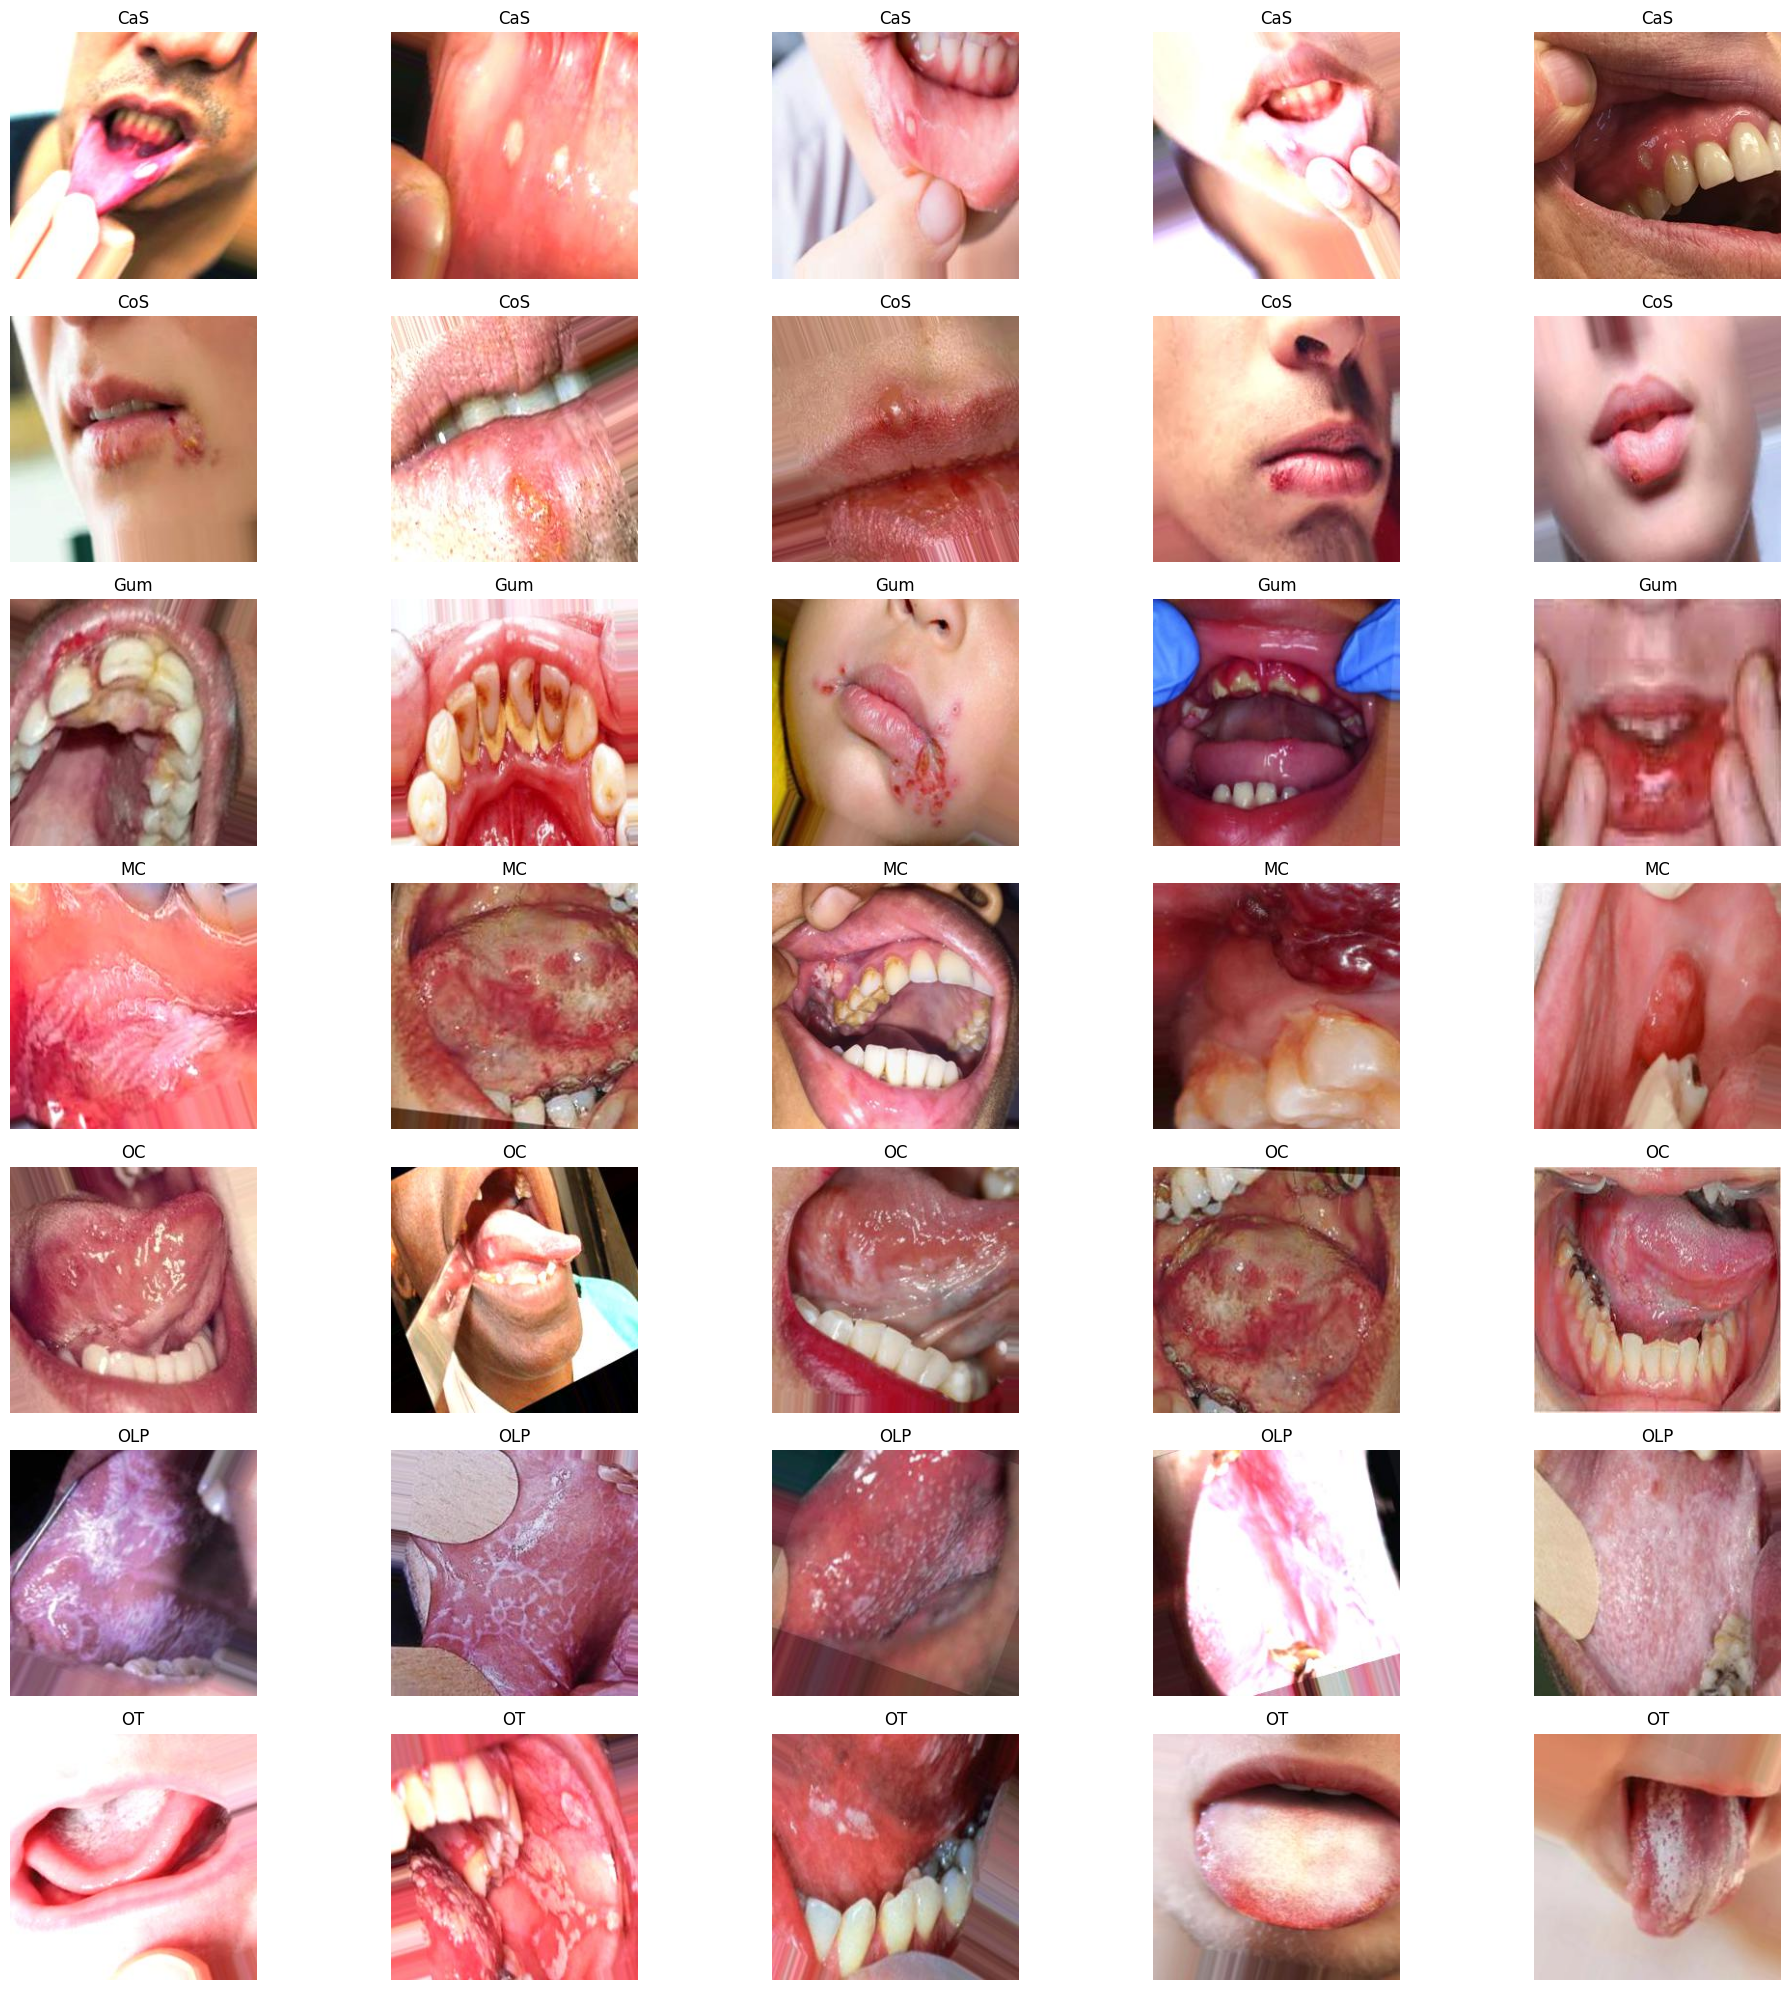

In [7]:
fig, axs = plt.subplots(7, 5, figsize=(20, 20))

# List of labels corresponding to each title
labels = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]

# Loop through each label and plot images
for idx, label in enumerate(labels):
    for i in range(5):
        axs.flat[i + 5 * idx].imshow(plt.imread(df.query(f'label == "{label}"')['filename'].iloc[i]))
        axs.flat[i + 5 * idx].set_title(label)
        axs.flat[i + 5 * idx].axis('off')

plt.tight_layout()
plt.show()


In [8]:
df['label'].value_counts(ascending=True)

label
OC     540
Gum    600
OT     655
CoS    748
CaS    800
MC     900
OLP    900
Name: count, dtype: int64

<ipython-input-9-32410f3219c0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


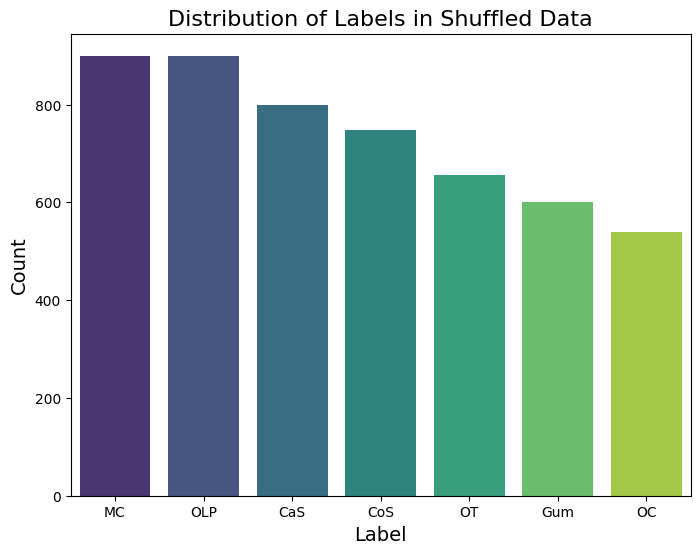

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each target label
label_counts = df['label'].value_counts()

# Plot the label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

# Add title and labels
plt.title('Distribution of Labels in Shuffled Data', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the plot
plt.show()


## Preprocessing

### resize and scale images

In [ ]:
def load_and_scale_image(image_path, target_size=(224, 224)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure image is in RGB format
        img = img.resize(target_size)  # Resize image to target size
        img_array = np.array(img)  # Convert to numpy array
        img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array


In [ ]:
# Assuming df is your DataFrame
df['scaled_image'] = df['filename'].apply(lambda x: load_and_scale_image(x, target_size=(224, 224)))


In [ ]:
df['scaled_image']


0       [[[0.6196078431372549, 0.3215686274509804, 0.3...
1       [[[0.5803921568627451, 0.27058823529411763, 0....
2       [[[0.7490196078431373, 0.6666666666666666, 0.4...
3       [[[0.8352941176470589, 0.6705882352941176, 0.7...
4       [[[0.8235294117647058, 0.6980392156862745, 0.6...
                              ...                        
5138    [[[0.10980392156862745, 0.2235294117647059, 0....
5139    [[[0.9647058823529412, 0.9019607843137255, 0.9...
5140    [[[0.6, 0.30980392156862746, 0.305882352941176...
5141    [[[0.615686274509804, 0.3568627450980392, 0.29...
5142    [[[0.6352941176470588, 0.45098039215686275, 0....
Name: scaled_image, Length: 5143, dtype: object

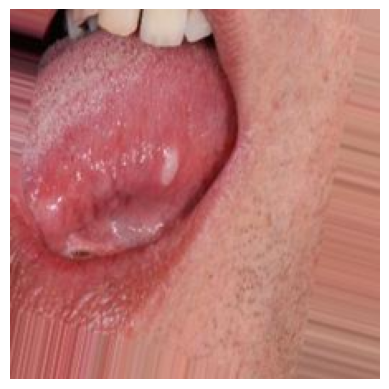

In [ ]:
# Select the first scaled image
scaled_image = df['scaled_image'].iloc[0]

# Display the image
plt.imshow(scaled_image)
plt.axis('off')  # Hide axes
plt.show()


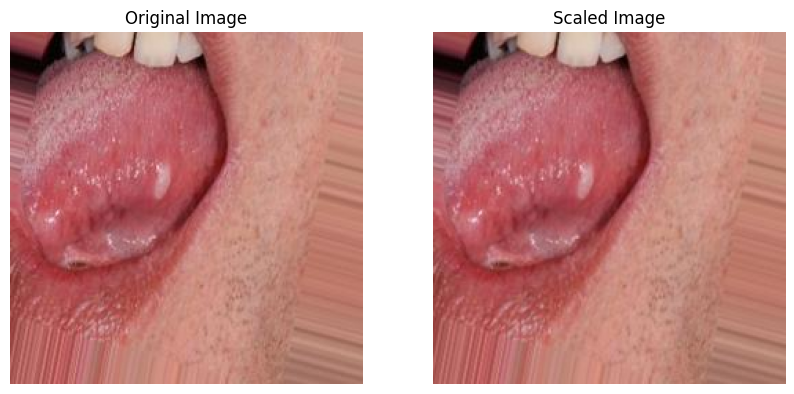

In [ ]:
# Import Matplotlib
import matplotlib.pyplot as plt

# Select the first original and scaled images
original_image_path = df['filename'].iloc[0]
scaled_image = df['scaled_image'].iloc[0]

# Load the original image using PIL
original_image = Image.open(original_image_path)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axes

# Display the scaled image
axes[1].imshow(scaled_image)
axes[1].set_title('Scaled Image')
axes[1].axis('off')  # Hide axes

# Show the images
plt.show()


In [ ]:
df

filename   partition label  \
0     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
1     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
2     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
3     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
4     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
...                                                 ...         ...   ...   
5138  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   
5139  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   
5140  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   
5141  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   
5142  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   

                                           scaled_image  
0     [[[0.6196078431372549, 0.3215686274509804, 0.3...  
1     [[[0.5803921568627451, 0.27058823529411763, 0....  
2     [[[0.7490196078431373, 0.6666666666666666, 0.4...  
3     [[[0.8352941176470589, 0.6705882352941176, 0.7...  
4     [[[0.8235294117647058, 0.6980392156862745, 0.6...  
...                                                 ...  
5138  [[[0.10980392156862745, 0.2235294117647059, 0....  
5139  [[[0.9647058823529412, 0.9019607843137255, 0.9...  
5140  [[[0.6, 0.30980392156862746, 0.305882352941176...  
5141  [[[0.615686274509804, 0.3568627450980392, 0.29...  
5142  [[[0.6352941176470588, 0.45098039215686275, 0....  

[5143 rows x 4 columns]

### split data to train, valid and test

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Extract scaled images and labels
X = np.array(df['scaled_image'].tolist())
y = np.array(df['label'])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Train, validation, and test split
train_mask = df['partition'] == 'Training'
valid_mask = df['partition'] == 'Validation'
test_mask = df['partition'] == 'Testing'

X_train, y_train = X[train_mask], y_categorical[train_mask]
X_valid, y_valid = X[valid_mask], y_categorical[valid_mask]
X_test, y_test = X[test_mask], y_categorical[test_mask]


In [ ]:
X_train.shape

(3087, 224, 224, 3)

In [ ]:
y_categorical

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_image_generator = ImageDataGenerator(
   rescale=1/255,
)


train_gen = image_generator.flow(X_train, y_train, batch_size=16 )
#valid_gen = val_image_generator.flow(X_valid, y_valid, batch_size=16 )
#test_gen = val_image_generator.flow(X_test, y_test, batch_size=16 )


### balance class weigts

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))


In [ ]:
class_weights

{0: 0.9183928571428571,
 1: 0.9822383498854087,
 2: 1.2245238095238096,
 3: 0.8163492063492064,
 4: 1.3605820105820106,
 5: 0.8163492063492064,
 6: 1.1217011995637949}

## Model Traning

### Training using CNN Model

In [ ]:


model = Sequential([
    # Input layer
    Input(shape=(128, 128, 3)),

    # First block of convolutional layers
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.2),  # Spatial dropout

    # Second block of convolutional layers
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.1),  # Spatial dropout

    # Third block of convolutional layers
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.1),  # Spatial dropout

    # Fourth block of convolutional layers
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.2),  # Spatial dropout

    # Flatten and fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),  # Regular dropout in the dense layer
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_14            │ (None, 64, 64, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_15            │ (None, 32, 32, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_16            │ (None, 16, 16, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_17            │ (None, 8, 8, 256)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,584,775 (17.49 MB)

 Trainable params: 4,584,775 (17.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model.compile(optimizer=Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:

# Early stopping and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)


history = model.fit(
    train_gen,
    epochs=70,
    validation_data=[X_valid, y_valid],
    callbacks=[early_stopping, model_checkpoint,lr_scheduler],

)


Epoch 1/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.1859 - loss: 1.9479 - val_accuracy: 0.1741 - val_loss: 1.9071 - learning_rate: 1.0000e-04
Epoch 2/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.2059 - loss: 1.8895 - val_accuracy: 0.3813 - val_loss: 1.7396 - learning_rate: 1.0000e-04
Epoch 3/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.3051 - loss: 1.7558 - val_accuracy: 0.4125 - val_loss: 1.5769 - learning_rate: 1.0000e-04
Epoch 4/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.3500 - loss: 1.6542 - val_accuracy: 0.4416 - val_loss: 1.4904 - learning_rate: 1.0000e-04
Epoch 5/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.4130 - loss: 1.5524 - val_accuracy: 0.4407 - val_loss: 1.4754 - learning_rate: 1.0000e-04
Epoch 6/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.4436 - loss: 1.4860 - val_accuracy: 0.4825 - val_loss: 1.3554 - learning_rate: 1.0000e-04
Epoch 7/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/st

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9460 - loss: 0.1617
Test Accuracy: 0.9377


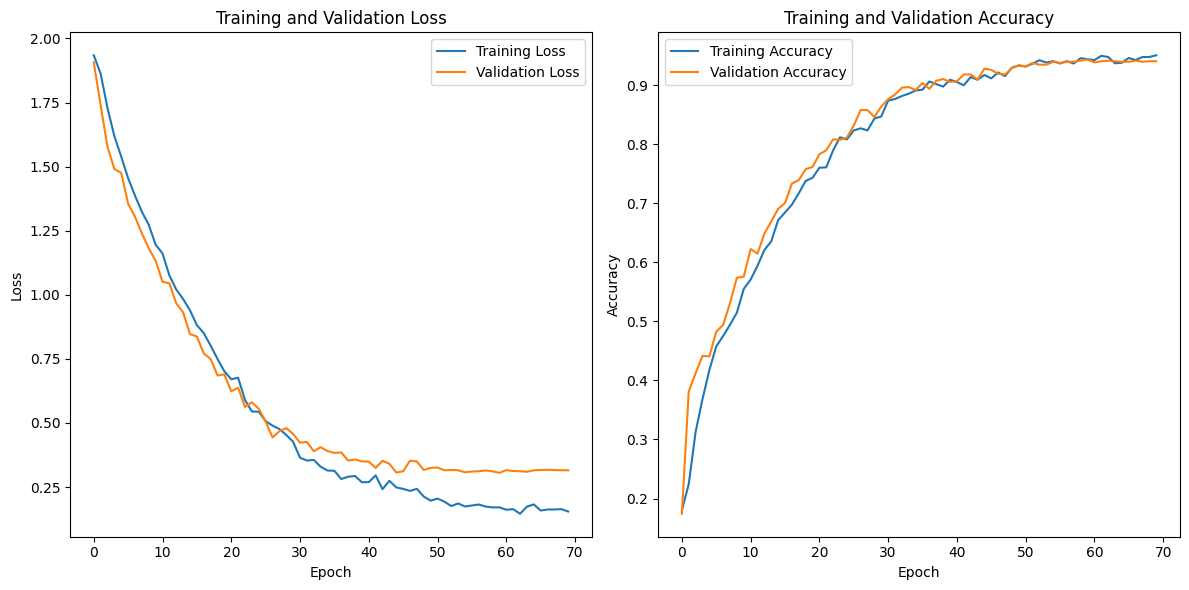

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


### Training Using Transfer Learning (MobileNet)

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Dense layer
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))


In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(train_gen,
                    steps_per_epoch=len(X_train) // 16,  # Adjust the batch size accordingly
                    epochs=50,  # Start with a small number of epochs, and increase if needed
                    validation_data=(X_valid, y_valid),
                    class_weight=class_weights,
                    callbacks=[lr_scheduler,early_stopping])


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/192 ━━━━━━━━━━━━━━━━━━━━ 42:28 13s/step - accuracy: 0.1875 - loss: 2.2338

I0000 00:00:1724894277.764327     166 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724894277.804169     166 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/192 ━━━━━━━━━━━━━━━━━━━━ 59s 241ms/step - accuracy: 0.3608 - loss: 1.7308 - val_accuracy: 0.7023 - val_loss: 0.9143 - learning_rate: 1.0000e-04
Epoch 2/50
  1/192 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6250 - loss: 0.9530

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6250 - loss: 0.9530 - val_accuracy: 0.7033 - val_loss: 0.9158 - learning_rate: 1.0000e-04
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - accuracy: 0.6348 - loss: 0.9890 - val_accuracy: 0.7802 - val_loss: 0.7121 - learning_rate: 1.0000e-04
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6250 - loss: 1.1401 - val_accuracy: 0.7811 - val_loss: 0.7089 - learning_rate: 1.0000e-04
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step - accuracy: 0.7234 - loss: 0.7562 - val_accuracy: 0.8288 - val_loss: 0.5775 - learning_rate: 1.0000e-04
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8750 - loss: 0.4661 - val_accuracy: 0.8220 - val_loss: 0.5778 - learning_rate: 1.0000e-04
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step - accuracy: 0.7704 - loss: 0.6273 - val_accuracy: 0.8395 - val_loss: 0.5189 - learning_rate: 1.0000e-04
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9885 - loss: 0.0772
Test Accuracy: 0.9873540997505188


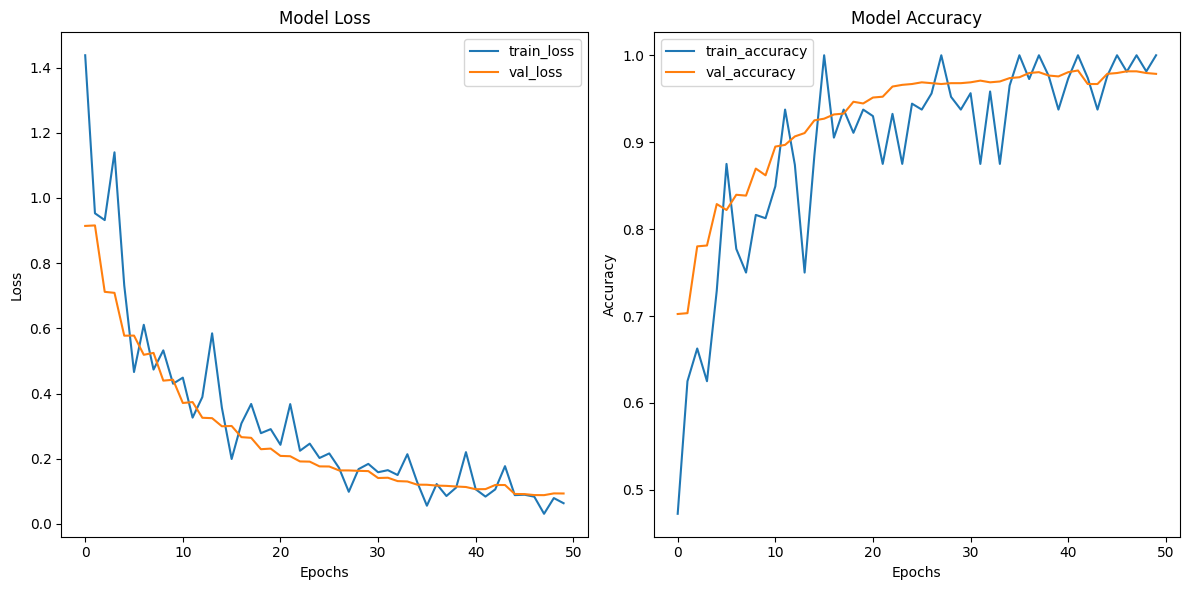

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Save Model
model.save('teeth_model.h5')


In [ ]:
# Save in Keras format
model.save('teeth_model.keras')


In [ ]:
# Load the weights from the saved .h5 file
model.load_weights('teeth_model.h5')